# FINANCIAL ASSET PRICE PREDICTOR : UDACITY DATA SCIENTIST CAPSTONE PROJECT

# Project overview

This project is the capstone project of Udacity Data Scientist nano-degree. For this project, I built a model to predict stock/ETF (Exchange Traded Funds)
prices. My personal professional background is in Finance and Investments. One of the reasons why I’m learning Data Science is to utility this powerful tool in the financial sector. The modern  Financial sectors consumers and generate enormous amount of date on daily basis. More than 90% of the daily trading volume of the major stock exchanges are conducted by computer program and algorithms. Machine learning and deep learning has become an essential tool for automate complicated trading decision making and trade execution process.  

In this project, I’m using LSTM model to predict stocks/ asset price a day in the future. Long short-term memory model( LSTM) is a RNN ( Recurrent Neural Network) architecture. LSTMs are extremely effective tool for sequence prediction problems. Since LTSM has feedback connection, it’s good at processing sequential of data, such as : historical financial assets prices. 


### Import all the libraries and packages 

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas_datareader import data as pdr 
import math 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#import powerful financil data plot libs
# pip install cufflinks
import cufflinks as cf
import plotly.offline as plyo
plyo.init_notebook_mode(connected = True)
%matplotlib inline
print('libraries imported')

libraries imported


## Data Exploration and Data Visualization

### Download the Financial Data : Historical  Asset price

* In this project I used python package yfinance to download historical  stock prices
* For more information about this python package, please visit https://pypi.org/project/yfinance/

In [5]:
# First define a function to download data as dataframe 
# yfiance valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# The default interval is '1d')
# This function can take a single symbol or multiple symbol separated by space

def download_data(symbol, start_date, end_date, interval):
    '''input: symbol as string. It can be single ticker symbol or multiple symbol separated by space
              start_date & end_date as str, e.g:2017-01-01 
              intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3m        
              The default interval is '1d')
       output: return a dataframe with col open, high, low , close, Adj Close
    '''
    yf.pdr_override() 
    data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date, interval = interval)
    return data 

##### Download Stock Price data

* With yfinance library, you can download one or multiple stocks' price
* However, if we download multiple stocks price, the data will have multiple levels of column names, so we need to flat the column names

In [6]:
# download the data
# download multiple historical price of stocks and index
# this function can be used to download multiple or single stock/financial asset
# AAPL: ticker symbol of Apple stock,  ^VIX the ticker symbol of COBE volatility index
dataMulti = download_data("AAPL QQQ MSFT ^VIX", "2000-01-01", "2022-03-30","1d")

[*********************100%***********************]  4 of 4 completed


In [7]:
# inspected the data downloaded 
dataMulti.head()

Adj Close                                      Close            \
                AAPL       MSFT        QQQ       ^VIX      AAPL      MSFT   
Date                                                                        
1999-12-31  0.786033  36.777348  79.050415  24.639999  0.917969  58.37500   
2000-01-03  0.855796  36.718277  81.970169  24.209999  0.999442  58.28125   
2000-01-04  0.783644  35.477936  76.346878  27.010000  0.915179  56.31250   
2000-01-05  0.795111  35.852016  74.400352  26.410000  0.928571  56.90625   
2000-01-06  0.726304  34.651043  69.290749  25.730000  0.848214  55.00000   

                                     High           ...      Low             \
                 QQQ       ^VIX      AAPL     MSFT  ...      QQQ       ^VIX   
Date                                                ...                       
1999-12-31  91.37500  24.639999  0.918527  58.8750  ...  91.3750  24.450001   
2000-01-03  94.75000  24.209999  1.004464  59.3125  ...  90.7500  23.980000   
2000-01-04  88.25000  27.010000  0.987723  58.5625  ...  87.9375  24.799999   
2000-01-05  86.00000  26.410000  0.987165  58.1875  ...  84.2500  25.850000   
2000-01-06  80.09375  25.730000  0.955357  56.9375  ...  79.7500  24.700001   

                Open                                   Volume            \
                AAPL      MSFT      QQQ       ^VIX       AAPL      MSFT   
Date                                                                      
1999-12-31  0.901228  58.75000  92.6250  25.030001  163811200  12517600   
2000-01-03  0.936384  58.68750  96.1875  24.360001  535796800  53228400   
2000-01-04  0.966518  56.78125  92.0000  24.940001  512377600  54119000   
2000-01-05  0.926339  55.56250  87.5000  27.980000  778321600  64059600   
2000-01-06  0.947545  56.09375  86.8750  26.680000  767972800  54976600   

                           
                 QQQ ^VIX  
Date                       
1999-12-31  14464400    0  
2000-01-03  36345200    0  
2000-01-04  33786600    0  
2000-01-05  42496600    0  
2000-01-06  37134800    0  

[5 rows x 24 columns]

* Open, the price at the open of a trading day 
* Close, is the price at the close of a trading day
* Adj Close: The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. Such as stock splits
* High, the highest price of a trading day
* Low, the lowest price of a trading day

In [8]:
# for multiple tickers, the column name of this dataframe has multiple levels, we need to flatten it
def rename_column(df):
    '''
    input: a dataframe with multiple levels of column name
    output: a dataframe with flated column name 
    '''
    col = list(df.columns)
    newcol = [i[0] +' '+ i[1] for i in col]
    dfCOPY = df.copy()
    dfCOPY.columns = [''] * len(dfCOPY.columns)
    dfCOPY.columns = newcol
    return dfCOPY

In [9]:
stocks = rename_column(dataMulti)
stocks.head()

,Adj Close AAPL,Adj Close MSFT,Adj Close QQQ,Adj Close ^VIX,Close AAPL,Close MSFT,Close QQQ,Close ^VIX,High AAPL,High MSFT,...,Low QQQ,Low ^VIX,Open AAPL,Open MSFT,Open QQQ,Open ^VIX,Volume AAPL,Volume MSFT,Volume QQQ,Volume ^VIX
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.786033,36.777348,79.050415,24.639999,0.917969,58.37500,91.37500,24.639999,0.918527,58.8750,...,91.3750,24.450001,0.901228,58.75000,92.6250,25.030001,163811200,12517600,14464400,0
2000-01-03,0.855796,36.718277,81.970169,24.209999,0.999442,58.28125,94.75000,24.209999,1.004464,59.3125,...,90.7500,23.980000,0.936384,58.68750,96.1875,24.360001,535796800,53228400,36345200,0
2000-01-04,0.783644,35.477936,76.346878,27.010000,0.915179,56.31250,88.25000,27.010000,0.987723,58.5625,...,87.9375,24.799999,0.966518,56.78125,92.0000,24.940001,512377600,54119000,33786600,0
2000-01-05,0.795111,35.852016,74.400352,26.410000,0.928571,56.90625,86.00000,26.410000,0.987165,58.1875,...,84.2500,25.850000,0.926339,55.56250,87.5000,27.980000,778321600,64059600,42496600,0
2000-01-06,0.726304,34.651043,69.290749,25.730000,0.848214,55.00000,80.09375,25.730000,0.955357,56.9375,...,79.7500,24.700001,0.947545,56.09375,86.8750,26.680000,767972800,54976600,37134800,0


In [10]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5597 entries, 1999-12-31 to 2022-03-29
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close AAPL  5597 non-null   float64
 1   Adj Close MSFT  5597 non-null   float64
 2   Adj Close QQQ   5597 non-null   float64
 3   Adj Close ^VIX  5597 non-null   float64
 4   Close AAPL      5597 non-null   float64
 5   Close MSFT      5597 non-null   float64
 6   Close QQQ       5597 non-null   float64
 7   Close ^VIX      5597 non-null   float64
 8   High AAPL       5597 non-null   float64
 9   High MSFT       5597 non-null   float64
 10  High QQQ        5597 non-null   float64
 11  High ^VIX       5597 non-null   float64
 12  Low AAPL        5597 non-null   float64
 13  Low MSFT        5597 non-null   float64
 14  Low QQQ         5597 non-null   float64
 15  Low ^VIX        5597 non-null   float64
 16  Open AAPL       5597 non-null   float64
 17  Open MSFT      

In [11]:
# Check duplicate data
stocks.duplicated().sum()

0

In [12]:
duplicateRows = stocks[stocks.duplicated()]
duplicateRows.head(20)

,Adj Close AAPL,Adj Close MSFT,Adj Close QQQ,Adj Close ^VIX,Close AAPL,Close MSFT,Close QQQ,Close ^VIX,High AAPL,High MSFT,...,Low QQQ,Low ^VIX,Open AAPL,Open MSFT,Open QQQ,Open ^VIX,Volume AAPL,Volume MSFT,Volume QQQ,Volume ^VIX
Date,,,,,,,,,,,,,,,,,,,,,


In [13]:
# check missing data 
stocks.isna().sum()

Adj Close AAPL    0
Adj Close MSFT    0
Adj Close QQQ     0
Adj Close ^VIX    0
Close AAPL        0
Close MSFT        0
Close QQQ         0
Close ^VIX        0
High AAPL         0
High MSFT         0
High QQQ          0
High ^VIX         0
Low AAPL          0
Low MSFT          0
Low QQQ           0
Low ^VIX          0
Open AAPL         0
Open MSFT         0
Open QQQ          0
Open ^VIX         0
Volume AAPL       0
Volume MSFT       0
Volume QQQ        0
Volume ^VIX       0
dtype: int64

In [14]:
stocks.to_csv("downloadedDataMulti.csv")

### Explore Data, Data Visualization and the Simple Moving Average Strategy 

* This section is a demo about how can we utilise the data
* We will explore the data and define a simple moving average strategy. In order to keep it within the scope of this project, I won't discussing optimization of this strategy
* The book Python for Finance by Yves Hilpisch is extremely helpful
* In this section Generate Simple Moving Averages using Adjusted close price

There are two types of basic and simple trade strategies: trend following and mean reversion. A trend following strategy is to identify the stocks that are in up or down trend, we would like to long(buy) when the stock price is trending up, and short short selling) when the stock price is trending down.  A mean reversion trading strategy based on the assumption that a financial asset’s price will eventually reverse to the long-term mean.  So, we will sell an overbought asset and buy an overbought asset and expecting the price will reverse to the mean. The deviation from the long-term mean is measured by standard deviation. 

 Funds and trading house seldom use strategies that is so simple, however this project is not about how to earn money on the financial market. To keep it relevant and more understandable, in the Data Exploration section, I will demonstrate how to build a Simple Moving Average strategy which is a basic trend following strategy. If you are interested in more advanced topics, Udacity’s. AI For Trading nanodegree might be a good place to start

In [15]:
# We have downloaded multiple columns, but here we only need Adjusted close price
# Change the variable symbol if you need to run it with other stock data
# Define a function to cleanup data 
def cleanData(symbol, df):
    '''
       input: 
             df: a dataframe that contains stock data
             symbol: symbol of a stock that you're intereted in 
       output: cleaned dataframe with one column: price
    '''
    symbol = symbol
    close = stocks.loc[:, stocks.columns.str.startswith('Adj Close')]
    strSymbol = 'Adj Close '+ symbol
    stock = pd.DataFrame(close[strSymbol])
    stock.rename(columns={strSymbol: 'price'}, inplace=True)
    return stock 

In [16]:
# Clean the data and get a dataframe with the index of date and a col of price
# This dataset will be used in the later section as the input data of the model
symbol = 'QQQ'
stock = cleanData(symbol,stocks)
stock.head()

,price
Date,
1999-12-31,79.050415
2000-01-03,81.970169
2000-01-04,76.346878
2000-01-05,74.400352
2000-01-06,69.290749


In [17]:
# check missing data 
stock.isna().sum()

price    0
dtype: int64

#### Visualization: Financial Data plots 


* Candle chart is one of the most used charts among financial institutions and professional traders. The chart plot out Open, High, Low, Close  price of a financial instrument. 

* The function plotCandelChart ( ), takes a dataframe, period and symbol as input and plot out a candle chart with Bollinger Band and Relative Strength indictor (RSI)


In [18]:
def plotCandleChart(df,period,symbol):
    '''
        Input: 
             df: dataframe that contains historical pricing data
             period:an int numbr of days/interval, the last n days of the dataset
             symbol: the ticker symbol(a string) of the financial instrument
        Output:
             candle charts with bollinger band and RSI              
    '''
    subSet = df.tail(period)
    ticker = symbol
    OHLC = subSet[["Open " + ticker,"High "+ ticker,"Low "+ ticker, "Adj Close "+ ticker ]]
    OHLC.head()
    candle = cf.QuantFig(
             OHLC,
             title = ticker + " candle chart ",
             legend = 'top',
             name =ticker)

    candle.add_bollinger_bands(periods = 15,boll_std =2)
    candle.add_rsi(periods=14, showbands=True)
    plyo.iplot(
             candle.iplot(asFigure = True),
             image = 'png',
             filename = ticker + " candle chart ") 

In [19]:
# Plot the chart where the period = 100 days, symbol = "QQQ"
plotCandleChart(stocks,100,"QQQ")

#### Investigate the relationship between QQQ and Volatility Index (VIX) (the Ordinary least squares (OLS) regression)

In [127]:
LogReturns = stocks[["Adj Close ^VIX", "Adj Close QQQ"]]
LogReturns = np.log(LogReturns/LogReturns.shift(1))
LogReturns.dropna(inplace = True)
LogReturns.head()

,Adj Close ^VIX,Adj Close QQQ
Date,,
2000-01-03,-0.017605,0.036270
2000-01-04,0.109441,-0.071068
2000-01-05,-0.022464,-0.025826
2000-01-06,-0.026085,-0.071150
2000-01-07,-0.169424,0.116612


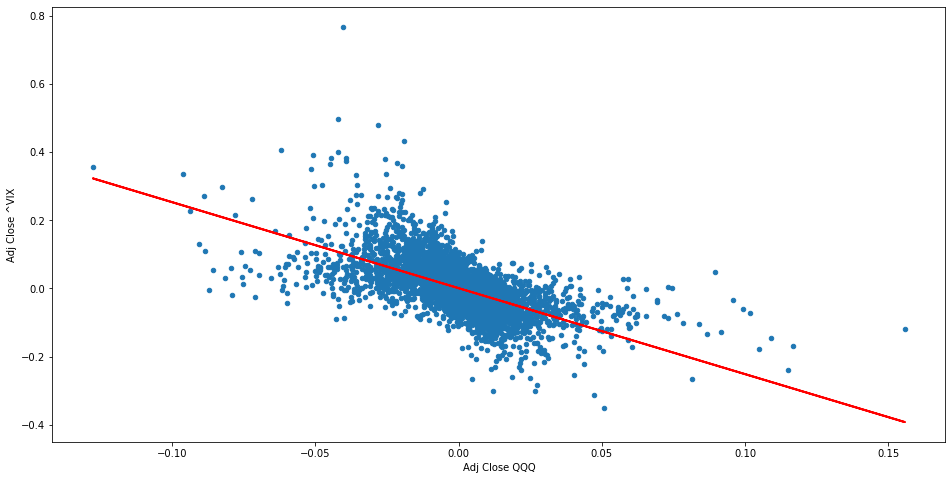

In [128]:
# Plot out the OLS 
reg = np.polyfit(LogReturns['Adj Close QQQ'],LogReturns['Adj Close ^VIX'], deg =1)
ax = LogReturns.plot(kind = 'scatter', x = 'Adj Close QQQ', y = 'Adj Close ^VIX', figsize =(16,8))
ax.plot(LogReturns['Adj Close QQQ'], np.polyval(reg, LogReturns['Adj Close QQQ']),'r', lw=2);


* As we can see from the plot above, the return of ETF QQQ has a strong negative correlation with Volatility index
* The higher the volatility the lower the return 

### Build and Visualized the Simple Moving Average strategy 

##### Simple Moving Average (SMA)  Formula 

SMA is a rather simple concept, it's just a rolling average 
SMA = ( Sum ( Price, n ) ) / n    
Where: n = Time Period

Don’t underestimate the power of simplicity. A profitable trading strategy doesn’t need to be overly complicated. The key is that the execution needs to be consistence.


In [129]:
# Define a funtion to generate Simple Moving average
# remember, SMA is just a rolling mean 
def SMA_Position(stock, smafast, smaslow):
    '''
       input: stock, a dataframe that contains stock data 
       smafast: an int number, fast moving average
       smaslow: an int number, slow moving average
       output: return the dataframe stock with an extra column,position 
    '''
    SmaFast = smafast
    SmaSlow = smaslow
    stock['SmaFast'] = stock['price'].rolling(SmaFast).mean()
    stock['SmaSlow'] = stock['price'].rolling(SmaSlow).mean()
    stock.dropna(inplace =True)
    # Long Position: Long a stock when the fast SMA is above slow SMA
    # Short Position: Short a stock when the slow SMA is above the fast SMA
    stock['Position'] = np.where(stock['SmaFast']> stock['SmaSlow'],1 ,-1)
    return stock

In [130]:
# Each year, there are around 254 trading days, so we use period n = 254 as slow moving average 
# Each month, on average there are 21 trading days, so we use period n = 42 as fast moving average
# Fast moving average with period n = 42
# Slowe moving average with period =  254
stock = SMA_Position(stock = stock, smafast=42,smaslow = 254)

In [131]:
stock.head()

,price,SmaFast,SmaSlow,Position
Date,,,,
2001-01-02,46.229877,59.311612,77.627302,-1
2001-01-03,54.015961,58.929259,77.528741,-1
2001-01-04,53.042706,58.503136,77.414853,-1
2001-01-05,48.987450,57.958574,77.307139,-1
2001-01-08,49.528164,57.439759,77.209217,-1


In [132]:
# caculate the log returns of 'buy and hold' and SMA strategy
stock['Return'] = np.log(stock['price']/stock['price'].shift(1))
stock['Strategy'] = stock['Position'].shift(1)*stock['Return']
stock.dropna(inplace =True)
stock.round(4).head()

,price,SmaFast,SmaSlow,Position,Return,Strategy
Date,,,,,,
2001-01-03,54.0160,58.9293,77.5287,-1,0.1557,-0.1557
2001-01-04,53.0427,58.5031,77.4149,-1,-0.0182,0.0182
2001-01-05,48.9874,57.9586,77.3071,-1,-0.0795,0.0795
2001-01-08,49.5282,57.4398,77.2092,-1,0.0110,-0.0110
2001-01-09,49.5282,56.9274,77.1314,-1,0.0000,-0.0000


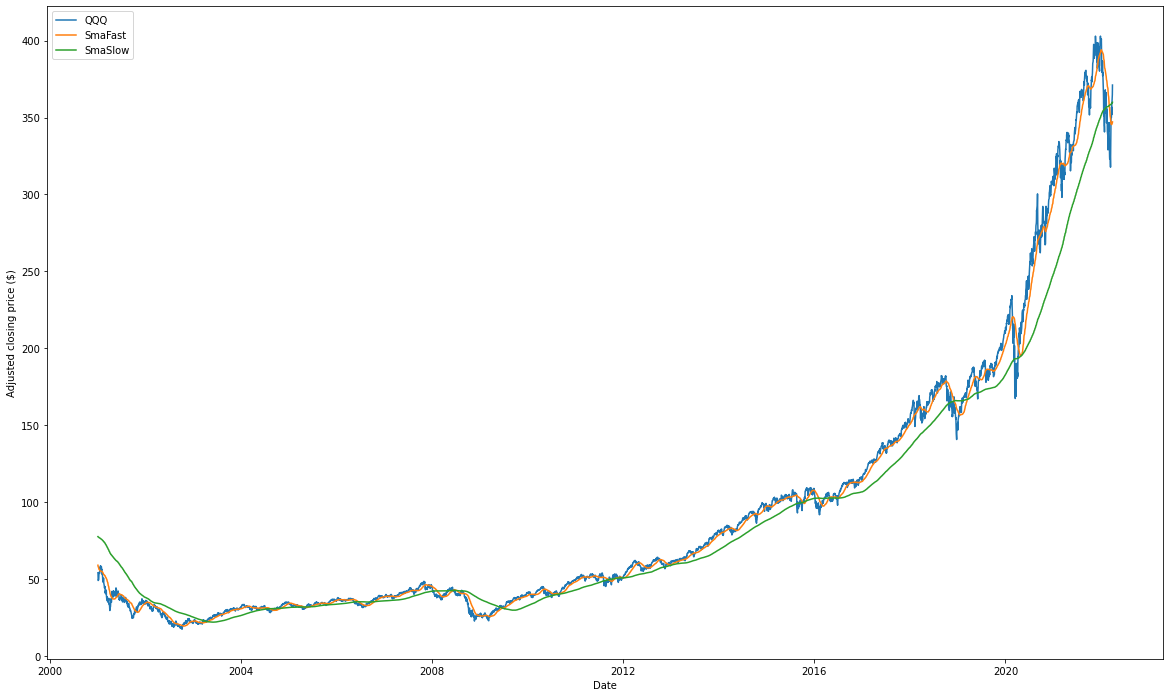

In [133]:
# Plot out the strategy
# We long/buy apple stock or derivatives if Fast Simple Moving Average is above Slow moving average 

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(stock.index, stock['price'], label= symbol)
ax.plot(stock.index, stock['SmaFast'], label='SmaFast')
ax.plot(stock.index, stock['SmaSlow'], label='SmaSlow')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()


In [134]:
np.exp(stock[['Return','Strategy']].sum())

Return      8.029223
Strategy    9.857583
dtype: float64

In [135]:
# caculate the annualized volatility
stock[['Return','Strategy']].std()*254**0.5

Return      0.251734
Strategy    0.251718
dtype: float64

   * As we can see from above, SMA strategy generate higher return than benchmark ("Buy and hold") 
   * The annualized volatility, is almost the same. SMA's volatility is slightly lower

#### Plot the Position( Long or Short) and Return of the strategy

* Blue Line: the cumulative return of the defined time period ( A simple buy and hold strategy)
* Orange Line: Simple Moving Average(SMA)strategy's return
* As you can see below, Given almost the same annulized volatilities, SMA strategy outperformed the "buy and hold" benchmark. 

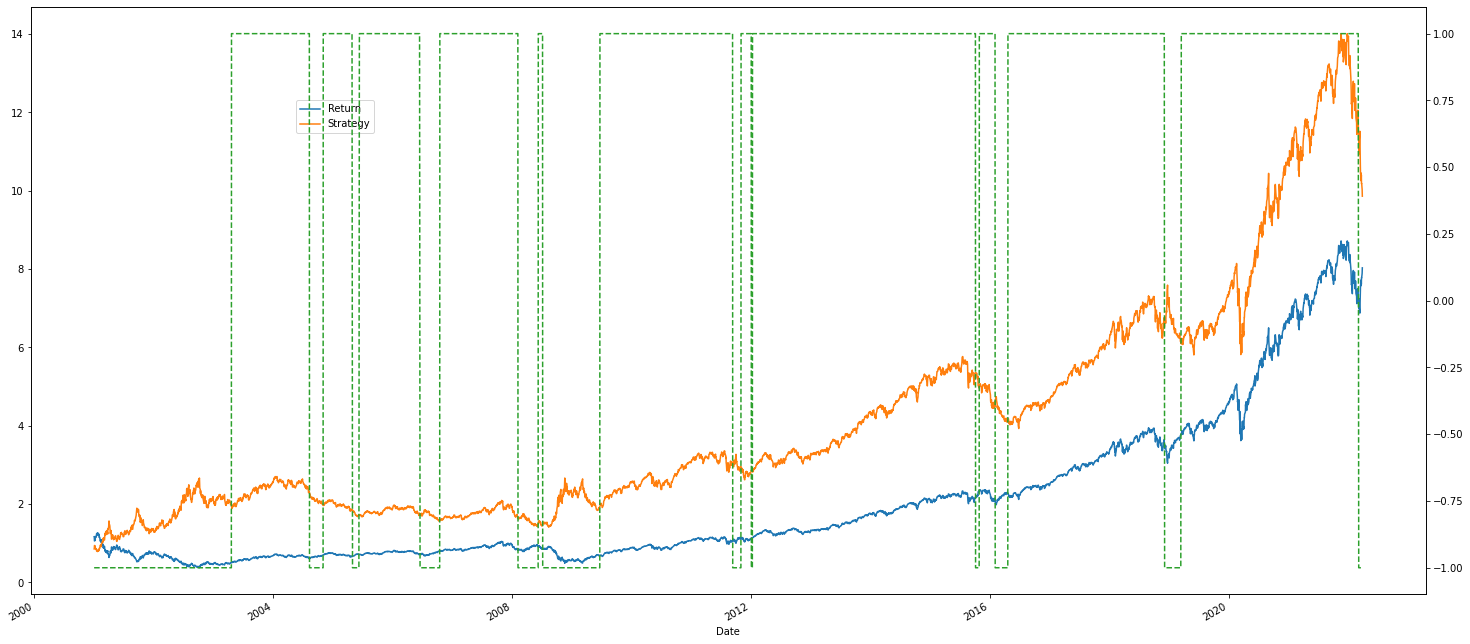

In [136]:
ax = stock[['Return', 'Strategy']].cumsum().apply(np.exp).plot(figsize =(25,12))
stock['Position'].plot(ax = ax, secondary_y ='Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85))


In [137]:
stock.head()

,price,SmaFast,SmaSlow,Position,Return,Strategy
Date,,,,,,
2001-01-03,54.015961,58.929259,77.528741,-1,0.155653,-0.155653
2001-01-04,53.042706,58.503136,77.414853,-1,-0.018182,0.018182
2001-01-05,48.987450,57.958574,77.307139,-1,-0.079533,0.079533
2001-01-08,49.528164,57.439759,77.209217,-1,0.010977,-0.010977
2001-01-09,49.528164,56.927382,77.131411,-1,0.000000,-0.000000


## Data Preprocessing

In [143]:
# First make a copy of cleaned dataframe 
data = stock

In [144]:
# only keep Adj Close(price) as a dataframe
PRICE = data.filter(['price'])
# convert the dataframe to a numpy array 
dataset = PRICE.values 
# Here we use 80% of the data as training data
train_data_len = math.ceil(len(dataset)* .8)
train_data_len

4275

#### Normalizing the Data and split data into training & testing sets


In [145]:
# Normalize and scale the data and transform it into a 0 to 1 range 
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0950701 ],
       [0.09254628],
       [0.08203028],
       ...,
       [0.88685505],
       [0.9012731 ],
       [0.91755824]])

In [146]:
# Create the training data set
# row: 0 to the lenght of training data, and get all the columns 
train_data = scaled_data[0: train_data_len, :]

In [147]:
# define x_train, y_train 
x_train =[]
y_train =[]
for i in range (50, len(train_data)):
    x_train.append(train_data[i-50:i,0])
    y_train.append(train_data[i,0])
    if i <= 51:
        print(x_train)
        print(y_train)
        #print()

[array([0.0950701 , 0.09254628, 0.08203028, 0.08343245, 0.08343245,
       0.09002244, 0.09394838, 0.09573616, 0.09405359, 0.09829505,
       0.10432421, 0.10376331, 0.10390354, 0.10702323, 0.10558607,
       0.09969716, 0.10204569, 0.10530566, 0.10474487, 0.0992485 ,
       0.10115534, 0.09307906, 0.09296692, 0.09319122, 0.09094785,
       0.08688728, 0.08152551, 0.08305106, 0.07894561, 0.08388106,
       0.08601235, 0.07867641, 0.07387546, 0.07053279, 0.0694111 ,
       0.06981494, 0.07199103, 0.06492425, 0.06144705, 0.06447558,
       0.05976444, 0.06167134, 0.06582169, 0.06586652, 0.06380259,
       0.05617495, 0.04989345, 0.05471678, 0.05314641, 0.04955692])]
[0.04742571105051864]
[array([0.0950701 , 0.09254628, 0.08203028, 0.08343245, 0.08343245,
       0.09002244, 0.09394838, 0.09573616, 0.09405359, 0.09829505,
       0.10432421, 0.10376331, 0.10390354, 0.10702323, 0.10558607,
       0.09969716, 0.10204569, 0.10530566, 0.10474487, 0.0992485 ,
       0.10115534, 0.09307906, 0.092

In [148]:
# convert the x_train , y_train to numpy arrays
# LSTM model is expecting 3 dimensional data, but we only have 2 dimensional --> reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4225, 50, 1)

## Implementation

#### Build And Compile the LSTM Model 


* The model has 4 LSTM layers, each has 100 dimensions of hidden unit. 
* Dropout, 20% of 100 neurons will be ignored randomly during each iteration.
* In the last layer return_sequences is False means there won’t be any feedback loop anymore, we are not going to add more layers. 
* Dense layer, unit =1, which means that the model only predict 1 price.
* The optimizer is: Nesterov Adam
* The loss function is : Mean Absolute Error 
* The batch size is 64
* The training process has 20 epochs  


An extremly nice blog posts about LSTM, Long and Short term memory model
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/

* Long short-term memory model( LSTM) is a RNN ( Recurrent Neural Network) architecture. LSTMs are extremely effective tool for sequence prediction problems. Since LTSM has feedback connection, it’s good at processing sequential of  historical data, such as : historical financial asset prices. 
* RNNs are analogous to the learning process of humans, just like us, it remembers some useful information from the past (feedback connection) and forget some none important information


In [179]:
model = Sequential()
# 1st lstm layer
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
# 2st lstm layer
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
# 3st lstm layer
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
# 4st lstm layer 
model.add(LSTM(units=100,return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mae')

#### Train the model 

"On sequence prediction problems, it may be desirable to use a large batch size when training the network and a batch size of 1 when making predictions in order to predict the next step in the sequence."

There is an intereting reading about batch_size on machinelearningmastery.com:
https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/


In [180]:
## train the model
model.fit(x_train,y_train, batch_size =64, epochs =20)

Epoch 1/20
67/67 [==============================] - 14s 137ms/step - loss: 0.0135
Epoch 2/20
67/67 [==============================] - 11s 171ms/step - loss: 0.0126
Epoch 3/20
67/67 [==============================] - 10s 146ms/step - loss: 0.0081
Epoch 4/20
67/67 [==============================] - 8s 113ms/step - loss: 0.0103
Epoch 5/20
67/67 [==============================] - 8s 112ms/step - loss: 0.0070
Epoch 6/20
67/67 [==============================] - 7s 111ms/step - loss: 0.0065
Epoch 7/20
67/67 [==============================] - 8s 118ms/step - loss: 0.0072
Epoch 8/20
67/67 [==============================] - 8s 119ms/step - loss: 0.0090
Epoch 9/20
67/67 [==============================] - 9s 127ms/step - loss: 0.0076
Epoch 10/20
67/67 [==============================] - 8s 123ms/step - loss: 0.0064
Epoch 11/20
67/67 [==============================] - 9s 136ms/step - loss: 0.0059
Epoch 12/20
67/67 [==============================] - 9s 130ms/step - loss: 0.0074
Epoch 13/20
67/67 [===

In [174]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 100)           40800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)              

### Refinement 
I have run this model with more LSTM layers and hidden units from 50 to 200. The results are similar. I have increased batch size from 32 to 64, the result improved. Moreover, I have increased the number of epochs, the differences are not significant. 


## Model Evaluation and Validation

In [181]:
# create test data set
test_data = scaled_data[train_data_len -50:, :]
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i,0])

x_test = np.array(x_test)

In [182]:
# reshape the data, becasue the lstm model is expecting a 3 dimensional dataset 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [183]:
# Use the model to predict the value 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions 

array([[153.91406],
       [153.8931 ],
       [153.94916],
       ...,
       [308.18207],
       [309.5841 ],
       [311.03726]], dtype=float32)

In [202]:
y_test.mean()

243.92064306709204

In [197]:
# Get the R2 Score 
# Get Mean Absolute Error
# Get the mean squared error (RMSE), the lower the value of RMSE, the better the model fits

print('R2 Score: ', r2_score(y_test, predictions))
print('MAE: ', mean_absolute_error(y_test, predictions))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, predictions)))

R2 Score:  0.9144246464180766
MAE:  15.6962864193577
RMSE:  23.236819708456302


In [195]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test, predictions)))

RMSE:  23.236819708456302


In [161]:
# create a validation dataset
train = data.iloc[: train_data_len]
finalDF = data.iloc[ train_data_len:]
finalDF['Predictions'] = predictions

In [199]:
finalDF.tail(20)

,price,SmaFast,SmaSlow,Position,Return,Strategy,Predictions
Date,,,,,,,
2022-03-02,346.791260,360.802035,357.675791,1,0.016640,0.016640,316.029388
2022-03-03,341.837402,359.480098,357.775614,1,-0.014388,-0.014388,315.600616
2022-03-04,336.883514,357.949134,357.892094,1,-0.014598,-0.014598,315.398010
2022-03-07,324.458862,356.246239,357.979458,-1,-0.037578,-0.037578,315.211609
2022-03-08,322.950745,354.797078,358.042962,-1,-0.004659,0.004659,314.696960
2022-03-09,334.576355,353.631139,358.186438,-1,0.035365,-0.035365,313.694397
2022-03-10,330.860962,352.475663,358.268993,-1,-0.011167,0.011167,312.465118
2022-03-11,323.999420,351.150872,358.328017,-1,-0.020957,0.020957,311.205505
2022-03-14,317.777161,349.542148,358.334524,-1,-0.019391,0.019391,309.913971


In [164]:
finalDF.to_csv("final_prediction.csv")

### Visualize the Model's Prediction 

Now we are going to visualize the LTSM model's prediction and compare the actual prices and predicited prices

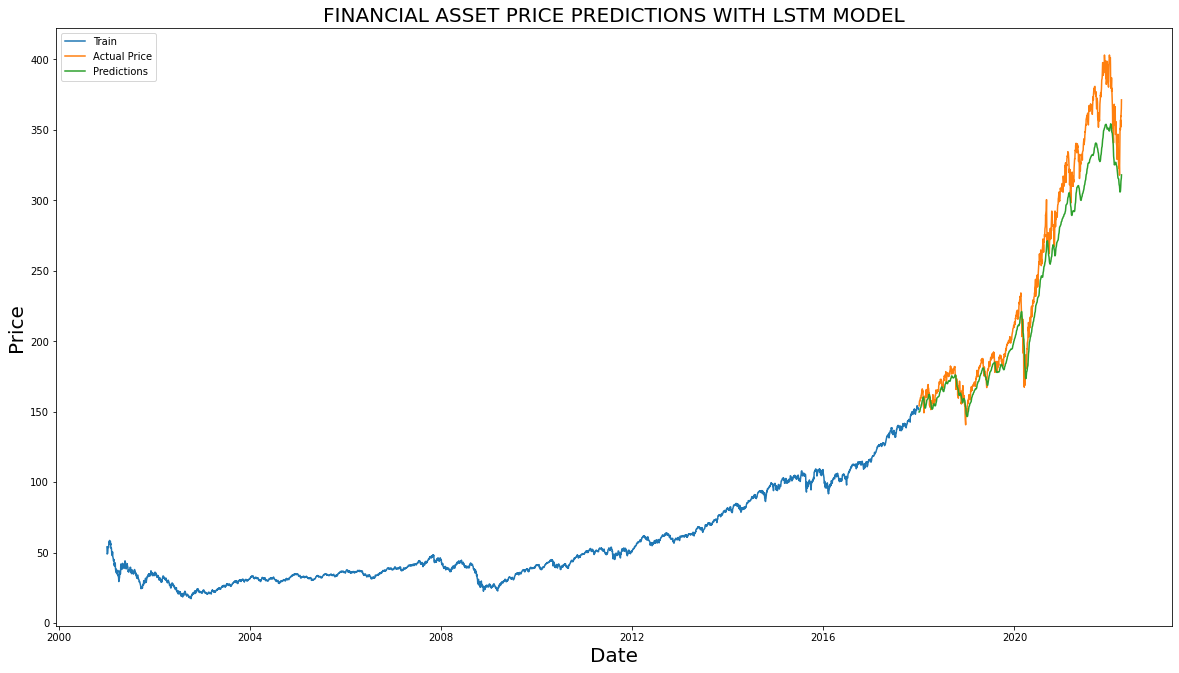

In [203]:
# plot out the actual price and the 
plt.figure(figsize =(20,11))
plt.title('FINANCIAL ASSET PRICE PREDICTIONS WITH LSTM MODEL',fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Price', fontsize =20)
plt.plot(train['price'])
plt.plot(finalDF[['price', 'Predictions']])
plt.legend(['Train','Actual Price','Predictions'], loc ='upper left')
plt.show()

The plot above showed us that:

* The blue line: training data
* The orange line is the actual price 
* The green line is the predciton that LSTM model made 

We can see that the predicted price follows the trend of actual price pretty well

#### Save the Model

In [204]:
# Pretty decent result, now lets save the model 
model.save('model.h5')

### Predict prices of other stocks and financial asset and evaluate the robustness of the LSTM

now we're going to use this model to predict different asset class: such as stock index and digital currency. 

In [232]:
# Define a function that download data and predict price of the desired financial asset
def predict_price(symbol,startdate,enddate,interval):
    '''
    input: symbol of the stock/financial instrument as a string
    input: startdate & enddate & interval as string
    output: predicted price for the next dag
    '''
    DFPred = download_data(symbol, startdate, enddate,interval)
    DFPred = DFPred.filter(['Adj Close'])
    # Get the last 50 day Adj Close price and convert the df into an array
    last_50_days = DFPred[-20:].values
    # Transform the data into value between 0 and 1
    last_50_days_scaled = scaler.transform(last_50_days)
    # Creat an empty list and append the last 50 days and convert it into numply array 
    X_test =[]
    X_test.append(last_50_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    # Get the predicted scaled price and undo the scaling
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    str_pred = str(pred_price[0][0])
    print( "The predicted price is " + str_pred)

##### Use the model to predict price of 1 day in the future and compare with the actual result

In [219]:
symbol = "QQQ"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 337.84024
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,398.279999,400.480011,386.640015,387.119995,386.148804,77766500


In [207]:
# Run the model in the future by load the model 
#model = keras.models.load_model('model.h5')

##### Let's use the model to predict the price of other stock and financial asset


In [208]:
symbol = "FB"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 308.0622
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,330.290009,330.5,310.290009,310.600006,310.600006,30329600


##### Evaluate the model and use the model to predict the price of Amsterdam AEX index

In [220]:
symbol = "^AEX"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-01", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 401.73883
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,783.840027,792.159973,783.840027,790.700012,790.700012,90800


##### Use the Model to predict the price of Microsoft stock

In [221]:
symbol = "MSFT"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new


[*********************100%***********************]  1 of 1 completed
The predicted price is 306.253
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,335.130005,339.279999,329.390015,330.079987,329.398895,33337600



##### Use the Model to predict the price of  Shell plc

In [222]:
symbol = "SHEL"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 44.74573
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,43.02,43.115002,41.560001,41.59,41.59,6006255


##### Use the Model to predict the price of HERMES

In [223]:
symbol = "RMS.PA"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
new = download_data(symbol, "2021-11-30", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 407.2176
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-30,1623.5,1676.5,1614.5,1653.0,1642.203613,206735
2021-12-01,1666.0,1678.0,1618.0,1668.5,1657.602539,70320


##### Use the Model to predict the price of bitcoin

In [224]:
symbol = "BTC-USD"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)
# The actual price
new = download_data(symbol, "2021-12-02", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed
The predicted price is 407.67273
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,56907.964844,59041.683594,56553.082031,57229.828125,57229.828125,36858195307


#### Model prediction of different assets class 

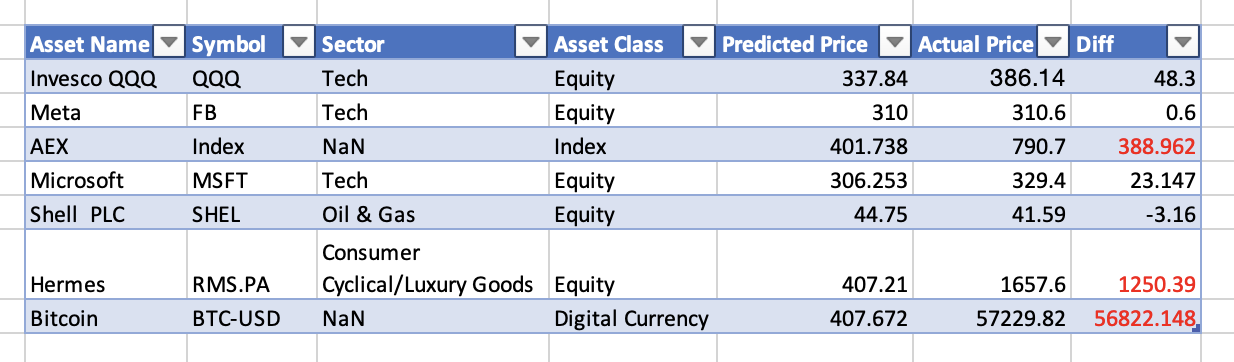

In [225]:
from IPython import display
display.Image("./result.png")


Took a look of this result, the model's prediction of Bitcoin price is not even close to the actual price at all. The same result showed up at prediction of  Hermes & AEX price. (Note: EX is a miner European Index(Amsterdam Exchange), which contains a basket of stocks across different sectors.)

It might have something to do with the fact that we have trained this model with an index Fund that tracks Tech companies. Difference financial instruments across sectors and asset’s class have different fundamentals and price movement patterns, they  behave in different way. Obviously, Bitcoin is a totally different creature than equity(stocks).

### Conclusion And Possible Improvements

This model is not robust enough, we simply cannot use this model to predict price of stock in other sectors. But, we should not expect one size fits all. Financial institutions and financial market professional rarely make investment decisions based on one signal or a simple prediction, they rely on fine designed architectures and decision processes. To summaries, the LTSM along is just too simply to forecast stock price, and trader&investor should definitely not trade according to the predictions alone. Financial market is an extremely complicated system , forecasting price movements is as difficult as forecasting weather. There are many factors can introduce unexpected dramatic changes of stock prices.

In reality, traders build models and trading strategy based on the classification of asset. If we want to incorporate this model in a realistic process, it’s better to build other models such as K-mean clustering and identify stocks that belongs to the same cluster, then apply prediction only within the cluster. Sometimes, It’s better to combine the results of different models. For example, utilize NLP sentiment analysis to evaluate the overall market sentiment, if the market sentiment is bearish and LTSM prediction also shows price drop, then we short-selling the stock; if the market sentiment is bullish and LTSM prediction also shows price increase, then we long the stock.







### References:

* Python for finance by Yves Hilpisch https://www.oreilly.com/library/view/python-for-finance/9781492024323/

* Time Series - LSTM Model https://www.tutorialspoint.com/time_series/time_series_lstm_model.htm

* Short-term stock market price trend prediction using a comprehensive deep learning system by Jingyi Shen & M. Omair Shafiq ttps://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00333-6

* P516, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow by Aurelien Geron 

